In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import scipy.fft as fft
import scipy.io as io

kwfft = {'norm': 'forward'}

In [3]:
# Read file

pathFile = "./Flowfield_Meunier.mat"
file_mat = io.loadmat(pathFile)

file_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fpsi_arr'])

In [4]:
# Get streamfunction

psi_hat_reduced = file_mat['Fpsi_arr']
psi_hat_reduced.shape

(513, 1024)

In [5]:
# Unreduce it using rfft2 (a bit of a cheat) and normalize it

psi = fft.irfft2(psi_hat_reduced.T, **kwfft)
psi /= np.sqrt(np.mean(psi**2))

psi_hat_beforeMask = fft.fft2(psi, **kwfft)
psi_hat_beforeMask.shape

(1024, 1024)

In [6]:
# Create the domain

resol = psi_hat_beforeMask.shape[0]

k1d = fft.fftfreq(resol, d=1./resol)
x1d = np.linspace(0, 2 * np.pi, resol, endpoint=False)

kx, ky = np.meshgrid(k1d, k1d, indexing='xy')
x, y = np.meshgrid(x1d, x1d, indexing='xy')

k_norm = np.sqrt(kx**2 + ky**2)

In [7]:
# Mask psi_hat to shorten spectrum extend

k_mask = 150
width_mask = 10

window = 0.5 * (1 - np.tanh((k_norm - k_mask) / width_mask))

psi_hat_afterMask = psi_hat_beforeMask * window


170 bins


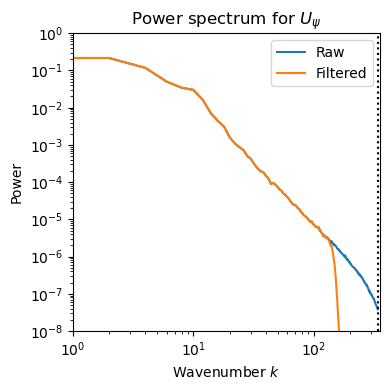

In [11]:
# Plot spectrum

k_max = kx.shape[1] / 3.
delta_k = 2.                # Step for radial integration

bins = np.arange(0, k_max, delta_k)

spectrum_before = np.empty(bins.size-1)
spectrum_after = np.empty(bins.size-1)

print(f"{bins.size-1} bins")

psi_PSD_before = np.abs(psi_hat_beforeMask)**2
psi_PSD_after = np.abs(psi_hat_afterMask)**2

for i in range(bins.size-1):
    maskBins = (bins[i] <= k_norm) * (k_norm < bins[i+1])
    spectrum_before[i] = np.sum(k_norm[maskBins]**2 * psi_PSD_before[maskBins])
    spectrum_after[i] = np.sum(k_norm[maskBins]**2 * psi_PSD_after[maskBins])

fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

ax.plot(bins[:-1], spectrum_before, label="Raw")
ax.plot(bins[:-1], spectrum_after, label="Filtered")

ax.set_title('Power spectrum for $U_{\\psi}$')
ax.set_xlabel('Wavenumber $k$')
ax.set_ylabel('Power')
ax.axvline(kx.shape[1] / 3., c='k', ls=':')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ybound([1e-8, 1])
ax.set_xbound([1,1024/2.9])
ax.legend()

plt.show()

In [24]:
# Dealias and mask 

psi_hat = psi_hat_afterMask / np.sqrt(np.sum(np.abs(psi_hat_afterMask)**2))

mask_aliasing_1d = ~(3 * np.abs(k1d) < resol)
psi_hat[mask_aliasing_1d,:] = 0.
psi_hat[:,mask_aliasing_1d] = 0.

psi = fft.ifft2(psi_hat, **kwfft).real
psi_lapl = fft.ifft2(-psi_hat * (kx**2 + ky**2), **kwfft).real
uTot = np.sqrt(fft.ifft2(1j * kx * psi_hat, **kwfft).real**2 + fft.ifft2(1j * ky * psi_hat, **kwfft).real**2)

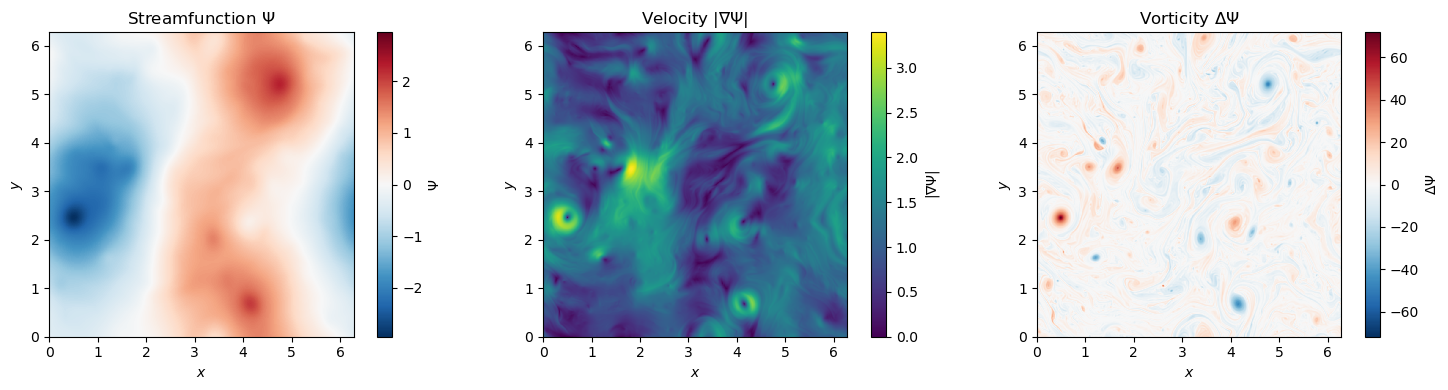

In [25]:
# Plot the streamfunction and the vorticity

magPsi = np.max(np.abs(psi))
magUtot = np.max(uTot)
magPsiLapl = np.max(np.abs(psi_lapl))

fig, ax = plt.subplots(figsize=(15,4), ncols=3, tight_layout=True)

p0 = ax[0].pcolormesh(x, y, psi, cmap='RdBu_r', vmin=-magPsi, vmax=magPsi)
p1 = ax[1].pcolormesh(x, y, uTot, cmap='viridis', vmin=0, vmax=magUtot)
p2 = ax[2].pcolormesh(x, y, psi_lapl, cmap='RdBu_r', vmin=-magPsiLapl, vmax=magPsiLapl)

fig.colorbar(p0, ax=ax[0], label="$\\Psi$")
fig.colorbar(p1, ax=ax[1], label="$|\\nabla \\Psi|$")
fig.colorbar(p2, ax=ax[2], label="$\\Delta \\Psi$")

ax[0].set_title('Streamfunction $\\Psi$')
ax[1].set_title('Velocity $|\\nabla \\Psi|$')
ax[2].set_title('Vorticity $\\Delta \\Psi$')

for axi in ax:
    axi.set_aspect(1)
    axi.set_xlabel('$x$')
    axi.set_ylabel('$y$')

plt.savefig('psi.png', dpi=200)
plt.show()


In [26]:
# Compute energy spectrum

k_max = kx.shape[1] / 3.
delta_k = 2.                # Step for radial integration

bins = np.arange(0, k_max, delta_k)
spectrum = np.empty(bins.size-1)

print(f"{bins.size-1} bins")

KEpsi_hat = np.abs(psi_hat)**2
k_norm = np.sqrt(kx**2 + ky**2)

for i in range(bins.size-1):
    maskBins = (bins[i] <= k_norm) * (k_norm < bins[i+1])
    spectrum[i] = KEpsi_hat[maskBins].sum()


170 bins


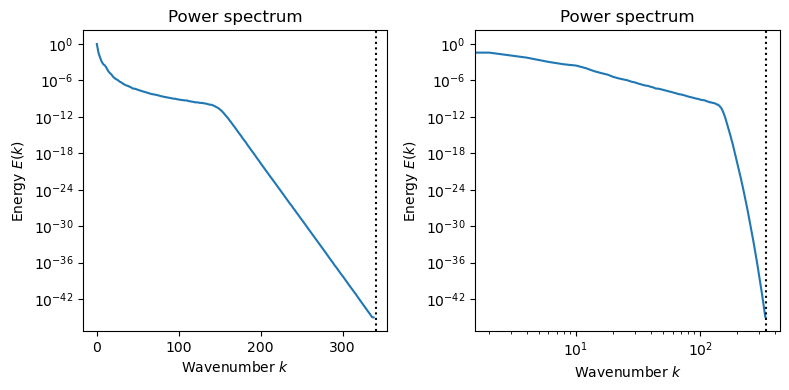

In [27]:
# Plot spectrum

fig, ax = plt.subplots(figsize=(8,4), ncols=2, tight_layout=True)

for axi in ax:
    axi.plot(bins[:-1], spectrum)
    axi.set_title(f'Power spectrum')
    axi.set_xlabel('Wavenumber $k$')
    axi.set_ylabel('Energy $E(k)$')
    axi.axvline(kx.shape[1] / 3., c='k', ls=':')

ax[0].set_yscale('log')
ax[0].set_xscale('linear')

ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.show()

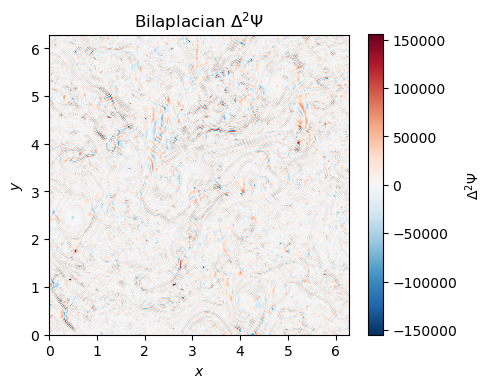

In [28]:
# Plot the bilaplacian

psi_bilapl = fft.ifft2(psi_hat * (kx**2 + ky**2)**2, **kwfft).real

magPsiBilapl = np.max(np.abs(psi_bilapl)) / 2

fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

p0 = ax.pcolormesh(x, y, psi_bilapl, cmap='RdBu_r', vmin=-magPsiBilapl, vmax=magPsiBilapl)

fig.colorbar(p0, ax=ax, label="$\\Delta^2 \\Psi$")

ax.set_title('Bilaplacian $\\Delta^2 \\Psi$')
ax.set_aspect(1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.savefig('psi_bilapl.png', dpi=200)
plt.show()

In [29]:
folderpath = os.getcwd()
print(folderpath)

/home/at278613/Documents/Inertial_Waves/Numerics/data_simu/2d/vortex_gaz/for_data_availability


In [30]:
# Save the data

savename = "psi.npz"
assert not os.path.isfile(os.path.join(folderpath, savename)), "Already existing file"

np.savez(os.path.join(folderpath, savename), 
         psi_hat=psi_hat, psi=psi, 
         x=x, y=y,
         kx=kx, ky=ky)